# Visual Analytics - Gummistiefel B

# Gruppe A

Phuc Tran Truong (558919)

Dennis Radtke (558896)

Arvid Matthes (558911)

---





## Aufgabenstellung & Überblick

Gummistiefel-Projekte
Daten:
Die Daten werden durch einen Webservice bereitgestellt. Dieser ist unter folgender URL erreichbar:

http://rz-vm154.gfz-potsdam.de:8080/highprecip/events/

Es gibt 2 Arten von Anfragen:
1. query: Rückgabe aller Ereignisse, welche innerhalb der gegebenen Parameterlimits liegen. Zur Einschränkung können alle Parameter des Ereignisses verwendet werden. Beispiele: id,
start, size, area, ... Des weiteren kann auch räumlich mithilfe des 'intersects' Befehls und
eines Polygons im WKT Format (well-known text) gefiltert werden.
2. get: (+ id) eines Ereignisses gibt die Ereignisdaten einschließlich der Ereigniszeitreihe
zurück. 

Beispiele:
- http://rz-vm154.gfz-potsdam.de:8080/highprecip/events/get?id=201600043
- http://rz-vm154.gfz-potsdam.de:8080/highprecip/events/get?id=201600043&format=geojson
- http://rz-vm154.gfz-potsdam.de:8080/highprecip/events/query?subset=length(20,100)&subset=si(0.1,0.3)&subset=area(2,5)
- http://rz-vm154.gfz-potsdam.de:8080/highprecip/events/query?subset=intersects(POLYGON ((11 53,15 53,15 51,11 51, 11 53)))&subset=area(1.0,10)

### Fragestellung B: Untersuchung der zeitlichen Entwicklung von Starkregenereignissen
Gegeben sind Starkregenereignisse der Jahre 1979-2017 für ein Gebiet, welches Deutschland, die Schweiz und Italien umfasst. Wissenschaftlerin Caliga interessiert sich für die Veränderung der Starkregenereignisse über die Zeit. Sie möchte Veränderungen der Eigenschaften der Starkregenereignisse untersuchen und mögliche Trends identifizieren. Welche konkreten Zeitintervalle dafür zusammengefasst werden müssen, kann nicht pauschal festgelegt werden. Für definierte Zeitintervalle möchte sie einen Überblick über die Eigenschaften der Starkregenereignisse bekommen. Als globale Referenz sollen die Eigenschaften der Starkregenereignisse über den gesamten Zeitraum herangezogen werden. Für eine eingehende Untersuchung möchte Caliga zwei der definierten Zeitintervalle detailliert vergleichen. Für diesen Detailvergleich sind einzelne, besonders extreme Ereignisse relevant, bspw. das zeitlich längste, das intensivste oder räumlich ausgedehnteste Ereignis. Zur abschließenden Bewertung möchte sie die raum-zeitliche Entwicklung dieser gewählten Extremereignisse ebenfalls untersuchen und vergleichen.

### Zusammenfassung:
Priorität: Zeitliche Entwicklung (nicht regionale Unterschiede)

Forscher:	Caliga

Wetter:		Starkregenereignisse

Gebiet:		Deutschland, Italien, Schweiz

Zeitraum:	1979-2017 

Hypothese:	Es existieren Trends bei Starkregenereignissen

Hypothese:	Es existieren (zeitliche) Veränderungen der Eigenschaften des Starkregens

Aufgabe:	vergleiche 2 definierte Zeitintervalle detailliert

Aufgabe:	vergleiche/ untersuche raum-zeitliche Entwicklung

Tipps:		- fasse bestimmte Zeitintervalle zusammen

 -ermittle extreme Ereignisse im Hinblick auf: lange Zeitdauer, Intensität, großer Raum


## 2. Datenexploration

### 2.1 Einlesen der Daten


In [1]:
import sys
sys.path.append("../")
import pandas as pd
from pathlib import Path
from gummistiefel.download_utils import *
import nest_asyncio 

nest_asyncio.apply()  # fixes bugs with event loops and jupyter notebooks

In [2]:
# Beispiel Get-Abfrage eines Ereignisses:

event_id = 201600043
event = get_event(event_id, geojson=True)
print(event)

{'area': 0.009999999776482582, 'id': '201600043', 'length': 1, 'si': 0.0, 'start': '2016-01-05T03:00:00', 'timeseries': {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [14.699999809265137, 40.959999084472656]}, 'properties': {'area': 0.009999999776482582, 'index': '201600043', 'latMax': 40.959999084472656, 'lonMax': 14.699999809265137, 'maxPrec': 4.630000114440918, 'meanPre': 4.630000114440918, 'si': 0.0, 'size': 1, 'stdv': 0.0}}]}}


In [3]:
# Beispiel Query-Abfrage zu Ereignissen mit gegebenen Parametern:

query = "subset=length(20,100)&subset=si(0.1,0.3)&subset=area(2,5)"
events = query_events(query, geojson=True)
pd.DataFrame(events).head()

,area,id,length,si,start,timeseries
0,4.25,198103100,20,0.19,1981-07-24T19:00:00,"{'type': 'FeatureCollection', 'features': [{'t..."
1,3.30,198205822,23,0.14,1982-11-01T02:00:00,"{'type': 'FeatureCollection', 'features': [{'t..."
2,3.76,198206453,22,0.12,1982-11-10T04:00:00,"{'type': 'FeatureCollection', 'features': [{'t..."
3,2.41,198400887,23,0.20,1984-03-23T19:00:00,"{'type': 'FeatureCollection', 'features': [{'t..."
4,2.98,198407734,21,0.21,1984-12-29T03:00:00,"{'type': 'FeatureCollection', 'features': [{'t..."


### 2.3. Plotting

Pakete zur Verarbeitung/ Analyse von Geodaten suchen und anwenden.
z.B.:
- https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html

Man kann die Daten im GeoJSON Format herunterladen. Dazu gibt es dann Pakete wie geojson. Mit geopandas kann man scheinbar besser mit geografischen Daten arbeiten. 

In [4]:
import seaborn as sns

### Eine Zeitreihe von einem Event:

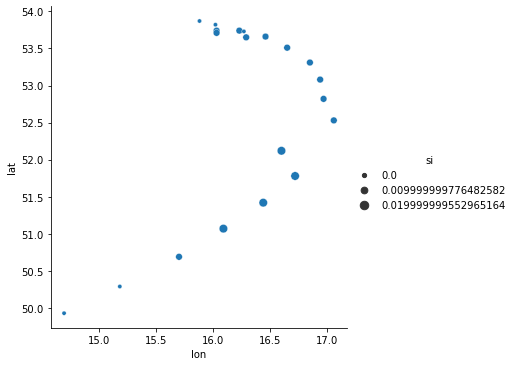

In [5]:
# Ereignisezeitreihe vom 24./25.07.1981 (20 Ereignisse):

event_id = 198103100
event = get_event(event_id, geojson=False)

time_series = pd.DataFrame(event['timeseries'])
_ = sns.relplot(
    x='lon',
    y='lat',
    size='si',
    data=time_series
)

### Gruppe von Events zu einer Query:

In [6]:
query = "subset=length(20,100)&subset=si(0.1,0.3)&subset=area(2,5)"
events = query_events(query, geojson=False)

In [7]:
# neue Variable "year" für Darsatellung der timeseries-Parameter:

precip_events_list = pd.DataFrame(events)['timeseries'].tolist()
precip_events = [
    time_series_element  for precip_event in precip_events_list for time_series_element in precip_event
]
years = [int(precip_event['date'][:4]) for precip_event in precip_events]
precip_events_df = pd.DataFrame(precip_events)
precip_events_df['year'] = years

In [8]:
precip_events_df.head()

,area,date,index,lat,latMax,lon,lonMax,maxPrec,meanPre,si,size,stdv,year
0,0.21,1981-07-24T19:00:00,198103100,49.930000,49.880001,14.690000,14.76,17.180000,12.70,0.00,14,2.38,1981
1,0.27,1981-07-24T20:00:00,198103100,50.290001,50.330002,15.180000,15.25,21.430000,14.05,0.00,18,4.21,1981
2,0.36,1981-07-24T21:00:00,198103100,50.689999,50.669998,15.700000,15.75,38.990002,21.24,0.01,24,9.33,1981
3,0.49,1981-07-24T22:00:00,198103100,51.070000,51.119999,16.090000,16.08,49.290001,26.73,0.02,33,12.91,1981
4,0.60,1981-07-24T23:00:00,198103100,51.419998,51.459999,16.440001,16.77,51.040001,26.35,0.02,40,13.11,1981


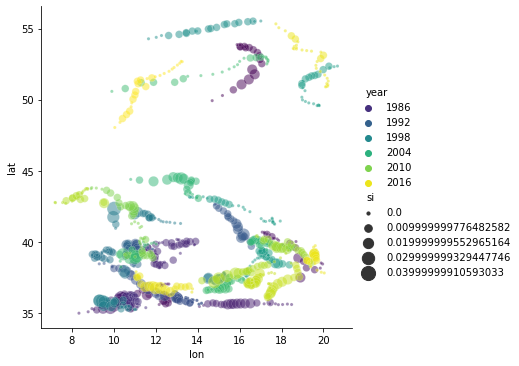

In [9]:
_ = sns.relplot(
    x='lon',
    y='lat',
    hue='year',
    size='si',
    sizes=(10,200),
    alpha=0.5,
    palette="viridis",
    data=precip_events_df
)

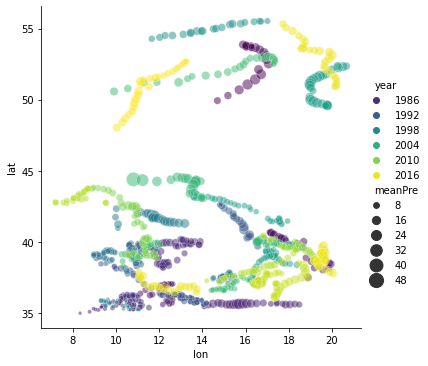

In [10]:
_ = sns.relplot(
    x='lon',
    y='lat',
    hue='year',
    size='meanPre',
    sizes=(10,200),
    alpha=0.5,
    palette="viridis",
    data=precip_events_df
)

Idealerweise würde man das irgendwie auf eine Landkarte malen, um eine Wetterkarte zu kriegen.

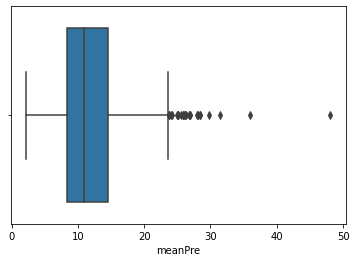

In [11]:
_ = sns.boxplot(x=precip_events_df['meanPre'])

### Gesamtzeitliche Betrachtung von Starkregenereignissen

In [12]:
events_df = pd.read_json('../data/regen_event_list_filtered.json', lines=True)

Text(0.5, 1.0, 'Zahl der Starkregenereignisse 1979-2017')

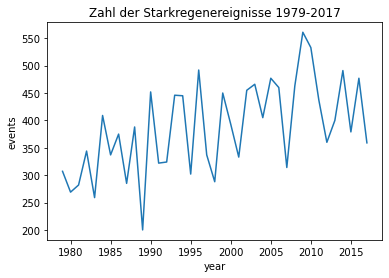

In [13]:
data = pd.DataFrame(
    events_df.groupby(['year']) \
    .id.count().reset_index(name='events')
    )
grouped_data = data.sort_values(['year','events'],ascending=False)
ax = sns.lineplot(
    y='events',
    x='year',
    palette=sns.color_palette("Paired"),
    data=grouped_data
)
ax.set_title("Zahl der Starkregenereignisse 1979-2017")

Text(0.5, 1.0, 'Durchschnittlicher Severity Index der Starkregenereignisse 1979-2017')

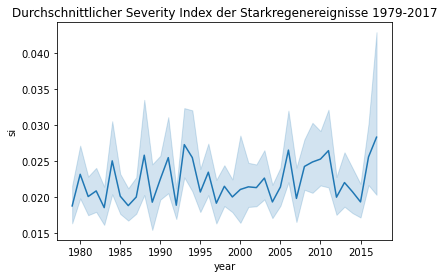

In [14]:
ax = sns.lineplot(x="year", y="si", data=events_df)
ax.set_title("Durchschnittlicher Severity Index der Starkregenereignisse 1979-2017")

Text(0.5, 1.0, 'Durchschnittliche Räumliche Ausdehnung der Starkregenereignisse 1979-2017')

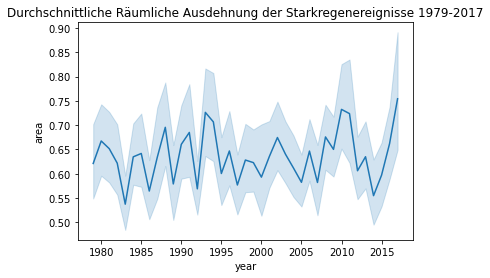

In [15]:
ax = sns.lineplot(x="year", y="area", data=events_df)
ax.set_title("Durchschnittliche Räumliche Ausdehnung der Starkregenereignisse 1979-2017")

Text(0.5, 1.0, 'Durchschnittliche Länge der Starkregenereignisse 1979-2017')

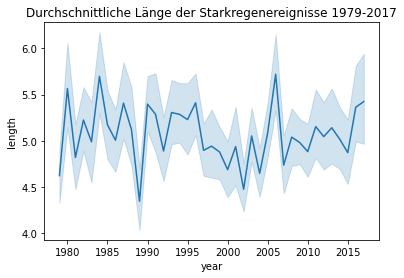

In [16]:
ax = sns.lineplot(x="year", y="length", data=events_df)
ax.set_title("Durchschnittliche Länge der Starkregenereignisse 1979-2017")

Ideen:
- Länderkarte einbinden & Daten darauf anzeigen lassen
- Alle Ereignisse mit allen Zeitreihen in einer Matrix speichern(?) Alternative?
   -> Ziel: Extrema ermitteln; "Starkregen" ermitteln (Ort, Zeit, Intensität)
   -> weglassen Daten die nicht in GER/IT/CHE liegen?
- Korrelationsmatrix zwischen si und length (sollten stark positiv korreliert sein..)
- 201706105 Extremwert... gibt viele Informationen relativ zu Ereigniszeitpunkten
- Äpfel & Birnen: geänderte Messbedingungen in Daten sichtbar?
- Varianz = stdv²
- tiefere Recherche Geoinformatik & QGis


## 2.4. Daten-Mapping

Georeferenz nach EPSG 4326 (
European Petroleum Survey Group Geodesy) i.V.m. ISO 19111 & WGS 84.

Mögliche Software hierfür: QGis ?

Siehe [EPSG3] für Überblick der Längen- & Breitengrade im Format (x=lon; y=lat) mit lon = Longitude & lat = Latitude

in [Umrechnung] lassen sich Koordinatendaten umrechnen

https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb#scrollTo=9mk5YrjXRxMP

https://thedatafrog.com/en/articles/show-data-google-map-python/

am besten Datensätze einblenden auf der bekannten Google Map? (3. Link)

## 2.5. Zeitliche Betrachtungen

- zeitlicher Verlauf eines Ereignisses
- Unterschiede monatlich/ wöchentlich/ jährlich/ täglich
- betrachtung Quartalweise/ Semester/ Trimester
- si werte im Zeitverlauf eines Ereignisses


## 2.6. Gesamtbetrachtung der Daten
Wie erhält man alle Daten? 
Weiß nicht, ob man das noch in Colab hinbekommt, weil die Session wahrscheinlich irgendwann nach einem Timeout beendet wird.
Daher eher mit einem Jupyter Notebook lokal oder noch besser ein Python Skript schreiben und auch lokal ausführen.

1.   Query (/Queries) verfassen, die alle Events umfassen, vielleicht in Monats oder Jahresschritten
2.   Als Json Datei auf lokales System schreiben

Mit `pandas` geht das Abspeichern relativ einfach, wenn man die Daten schon in eine `pandas.DataFrame` gepackt hat: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_json.html



Problem:
wenn ich im Code unten alle Datensätze von 1979 wähle (00001 bis 99999) erhalte ich den Fehlercode:

*TypeError: the JSON object must be str, bytes or bytearray, not TimeoutError*

Bei 00001 bis 05000 bspw. kommt der Fehler (noch) nicht.


In [17]:
import time

y0 = "1979"
y1 = "1979"
d0 = "00001"
d1 = "00100"

d0int = int(d0)
d1int = int(d1)

# Misst Startzeit
start = time.time()

query = "subset=id({}{},{}{})".format(y0,d0,y1,d1)
events = query_events(query, geojson=True)
df = pd.DataFrame(events)

# Struktureller Überblick
#print(df.head())

# Überblick Speicher
#print(df.info())

# Misst Endzeit
end = time.time()

# Datensätze aus ca. einem halben Jahr dauern bei mir lokal ca. 4min mittels Spyder 
print( "Es wurden", d1int - d0int + 1, "IDs abgefragt in", round(end - start, 2), "Sekunden bzw.", round((end - start)/60,2), "Minute(n)")

Es wurden 100 IDs abgefragt in 4.92 Sekunden bzw. 0.08 Minute(n)


## 3. Interaktivität

###3.1. ...

## 4. Quellen:
[Python] https://requests.readthedocs.io/en/master/user/quickstart/#response-content (11.11.2020 20:31*)

[Python2] https://realpython.com/python-concurrency/ (13.11.2020 19:11*)

[Methode] https://nhess.copernicus.org/articles/17/1177/2017/ (17.11.2020 15:31*)

[Geojson] https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html (22.11.2020 10:16*)

[EPSG] https://gisisit.wordpress.com/2013/12/03/epsg-codes-fur-deutschland/ (23.11.2020 15:12*)

[EPSG2] https://de.wikipedia.org/wiki/Koordinatenreferenzsystem (23.11.2020 15:18*)

[EPSG3] https://epsg.io/map#srs=4326&x=0.000000&y=0.000000&z=1&layer=streets (23.11.2020 17:29*)

[Umrechnung] https://www.kompf.de/trekka/geoposition.php (23.11.2020 17:51*)

[EPSG4] https://spatialreference.org/ref/epsg/wgs-84/ (23.11.2020 17:58*)

[Polygon] https://de.wikipedia.org/wiki/Simple_Feature_Access (24.11.2020 09:37*)

[Polygon2] https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry (24.11.2020 10:08*)


#####* Datum & Uhrzeit des letzten Zugriffs